In [1]:
# use sqlalchemy to setup the pap database
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import Tables
import random

In [2]:
# connect to the database, creating it and tables if necessary
engine = create_engine('sqlite:///pap.db')
Tables.Base.metadata.create_all(engine)


In [3]:
import os
import re

In [4]:
fns = os.listdir("../../TTGames/games/src/images")
fns = [fn for fn in fns if re.match(r"\d+", fn)]

In [5]:
pres_list = """41,George H. W. Bush
09,William Henry Harrison
33,Harry S. Truman
22,Grover Cleveland
42,Bill Clinton
05,James Monroe
21,Chester A. Arthur
20,James A. Garfield
10,John Tyler
31,Herbert Hoover
30,Calvin Coolidge
32,Franklin D. Roosevelt
04,James Madison
07,Andrew Jackson
35,John F. Kennedy
29,Warren G. Harding
37,Richard Nixon
13,Millard Fillmore
40,Ronald Reagan
23,Benjamin Harrison
01,George Washington
28,Woodrow Wilson
02,John Adams
12,Zachary Taylor
26,Theodore Roosevelt
06,John Quincy Adams
03,Thomas Jefferson
45,Donald Trump
18,Ulysses S. Grant
34,Dwight D. Eisenhower
44,Barack Obama
27,William Howard Taft
43,George W. Bush
15,James Buchanan
25,William McKinley
14,Franklin Pierce
19,Rutherford B. Hayes
46,Joe Biden
16,Abraham Lincoln
17,Andrew Johnson
11,James K. Polk
08,Martin Van Buren
36,Lyndon B. Johnson
38,Gerald R. Ford
39,Jimmy Carter"""

pres_list = pres_list.splitlines()

In [6]:
fns

['41-bush.jpg',
 '09-harrison.jpg',
 '33-truman.jpg',
 '22-24-cleveland.jpg',
 '42-clinton.jpg',
 '05-monroe.jpg',
 '21-arthur.jpg',
 '20-garfield.jpg',
 '10-tyler.jpg',
 '31-hoover.jpg',
 '30-coolidge.jpg',
 '32-roosevelt.jpg',
 '04-madison.jpg',
 '07-jackson.jpg',
 '35-kennedy.jpg',
 '29-harding.jpg',
 '37-nixon.jpg',
 '13-fillmore.jpg',
 '40-reagan.jpg',
 '23-harrison.jpg',
 '01-washington.jpg',
 '28-wilson.jpg',
 '02-adams.jpg',
 '12-taylor.jpg',
 '26-roosevelt.jpg',
 '06-adams.jpg',
 '03-jefferson.jpg',
 '45-donald-trump.png',
 '18-grant.jpg',
 '34-eisenhower.jpg',
 '44-obama.jpg',
 '27-taft.jpg',
 '43-bush.jpg',
 '15-buchanan.jpg',
 '25-mckinley.jpg',
 '14-pierce.jpg',
 '19-hayes.jpg',
 '46-joe-biden.png',
 '16-lincoln.jpg',
 '17-johnson.jpg',
 '11-polk.jpg',
 '08-van-buren.jpg',
 '36-johnson.jpg',
 '38-ford.jpg',
 '39-carter.jpg']

In [7]:
len(fns)

45

In [8]:
len(pres_list)

45

In [9]:
pres_list[0]

'41,George H. W. Bush'

In [10]:
presidents = []
for i in range(len(fns)):
    imageSrc = fns[i]
    id, name = pres_list[i].split(",")
    
    pres = Tables.President(id=id, name=name, image=imageSrc)
    presidents.append(pres)

sess = sessionmaker(bind=engine)()
sess.add_all(presidents)
sess.commit()
sess.close()


In [11]:
sess = sessionmaker(bind=engine)()

In [12]:
import pydantic
from typing import List

In [13]:
class President(pydantic.BaseModel):
    president_id: int
    name: str
    image: str

In [14]:
class Quiz(pydantic.BaseModel):
    id: int
    quote: str
    correct_answer: str
    choices: List[str]


In [15]:
all_presidents = [President(president_id=p.id, name=p.name, image=p.image) for p in sess.query(Tables.President).all()]

In [16]:
all_presidents[0].image

'01-washington.jpg'

In [17]:
def create_quiz(quote: str, correct_answer: Tables.President):
    random.shuffle(all_presidents)
    choices = [c.name for c in all_presidents[:3]]
    choices.append(correct_answer.name)

    sess = sessionmaker(bind=engine)()

    quiz = Tables.Quiz(
        quote=quote,
        correct_answer=correct_answer.name,
        choices=",".join(choices),
    )

    sess.add(quiz)
    sess.commit()

    result = Quiz(
        id=quiz.id,
        quote=quiz.quote,
        correct_answer=quiz.correct_answer,
        choices=[c for c in choices],
    )
    
    sess.close()

    return result

In [18]:
all_presidents

[President(president_id=1, name='George Washington', image='01-washington.jpg'),
 President(president_id=2, name='John Adams', image='02-adams.jpg'),
 President(president_id=3, name='Thomas Jefferson', image='03-jefferson.jpg'),
 President(president_id=4, name='James Madison', image='04-madison.jpg'),
 President(president_id=5, name='James Monroe', image='05-monroe.jpg'),
 President(president_id=6, name='John Quincy Adams', image='06-adams.jpg'),
 President(president_id=7, name='Andrew Jackson', image='07-jackson.jpg'),
 President(president_id=8, name='Martin Van Buren', image='08-van-buren.jpg'),
 President(president_id=9, name='William Henry Harrison', image='09-harrison.jpg'),
 President(president_id=10, name='John Tyler', image='10-tyler.jpg'),
 President(president_id=11, name='James K. Polk', image='11-polk.jpg'),
 President(president_id=12, name='Zachary Taylor', image='12-taylor.jpg'),
 President(president_id=13, name='Millard Fillmore', image='13-fillmore.jpg'),
 President(pres

In [17]:
q = Tables.Quiz(
    quote="I am the 41st president of the United States.",
    correct_answer="George H. W. Bush",
    choices="George H. W. Bush,Donald Trump,Joe Biden,Barack Obama",
    
)

In [23]:
q = create_quiz(
    quote="This is a test.",
    correct_answer=all_presidents[0]
)

In [25]:
# drop all quizzes
sess = sessionmaker(bind=engine)()
sess.query(Tables.Quiz).delete()
sess.commit()
sess.close()

In [14]:
all_presidents[0]

President(president_id=1, name='George Washington', image='01-washington.jpg')

In [18]:
import requests
import bs4

In [44]:
pres_list_page = requests.get("https://en.wikiquote.org/wiki/List_of_presidents_of_the_United_States")

In [47]:
plist = []
for p in pres_list:
    _, name = p.split(",")
    plist.append(name)

pages = {
    pres: f"https://en.wikiquote.org/wiki/{pres.replace(' ', '_')}"
    for pres in plist
}

In [19]:
def get_page(page):
    page = requests.get(page)
    return bs4.BeautifulSoup(page.text, "html.parser")

In [53]:
html_pages = {pres: get_page(page) for pres, page in pages.items()}

In [20]:
import pickle

In [57]:
for key in html_pages:
    with open(f"Quotes/{key}.html", "w") as f:
        f.write(str(html_pages[key]))



In [21]:
# load the html pages
html_pages = {}
for fn in os.listdir("Quotes"):
    with open(f"Quotes/{fn}", "r") as f:
        html_pages[fn[:-5]] = bs4.BeautifulSoup(f.read(), "html.parser")

In [22]:
keys = list(html_pages.keys())
keys[:5]

['Harry S. Truman',
 'Franklin Pierce',
 'Gerald R. Ford',
 'Millard Fillmore',
 'William Henry Harrison']

In [23]:
presidents = {
    n.name.replace(" ", "_"): n
    for n in all_presidents
}

In [24]:
def extract_quotes(soup):
    """
    Find a div with class "mw-parser-output".
    Find an h2 with the text "Quotes"
    Find all ul tags between that h2 and the next h2
    Add the first li text to quotes for each ul.

    """
    quotes = []
    div = soup.find("div", {"class": "mw-parser-output"})
    uls = []
    collect = False
    for tag in div.children:
        if tag.name == "h2":
            if tag.text == "Quotes[edit]" or tag.text == "Quotes":
                collect = True
            else:
                collect = False
        if collect and tag.name == "ul":
            uls.append(tag)

    for ul in uls:
        quotes.append(ul.find("li").text)


    return quotes

In [25]:
qs = extract_quotes(html_pages["Andrew Johnson"])

In [26]:
qs

['Whenever you hear a man prating about the Constitution, spot him as a traitor.\nRemark made by Johnson as military Governor of Tennessee, as quoted in A Review of the Political Conflict in America (1876) by Alexander Harris, A Review of the Political Conflict in America, p. 430.',
 'There are no good laws but such as repeal other laws.\nStatement (1835), as quoted in Andrew Johnson, Plebeian and Patriot (1928) by Robert Watson Winston.',
 'There are some who lack confidence in the integrity and capacity of the people to govern themselves. To all who entertain such fears I will most respectfully say that I entertain none... If a man is not capable, and is not to be trusted with the government of himself, is he to be trusted with the government of others... Who, then, will govern? The answer must be, Man — for we have no angels in the shape of men, as yet, who are willing to take charge of our political affairs.\nStatement (1853) as quoted in Andrew Johnson, Plebeian and Patriot (1928)

In [27]:
def create_quizes(quotes, president_name):
    quizes = []

    for quote in quotes:
        quote = quote.split("\n")[0].strip()

        q = create_quiz(
            quote=quote,
            correct_answer=president_name
        )

        print("Quiz created.", q)

In [28]:
pquotes = {}
for pname, pres in presidents.items():
    qs = extract_quotes(html_pages[pres.name])
    pquotes[pres.name] = qs

In [129]:
from matplotlib import pyplot as plt

In [130]:
import numpy as np

In [39]:
mean_q = sum([len(qs) for qs in pquotes.values()]) / len(pquotes)
std_q = np.std([len(qs) for qs in pquotes.values()])

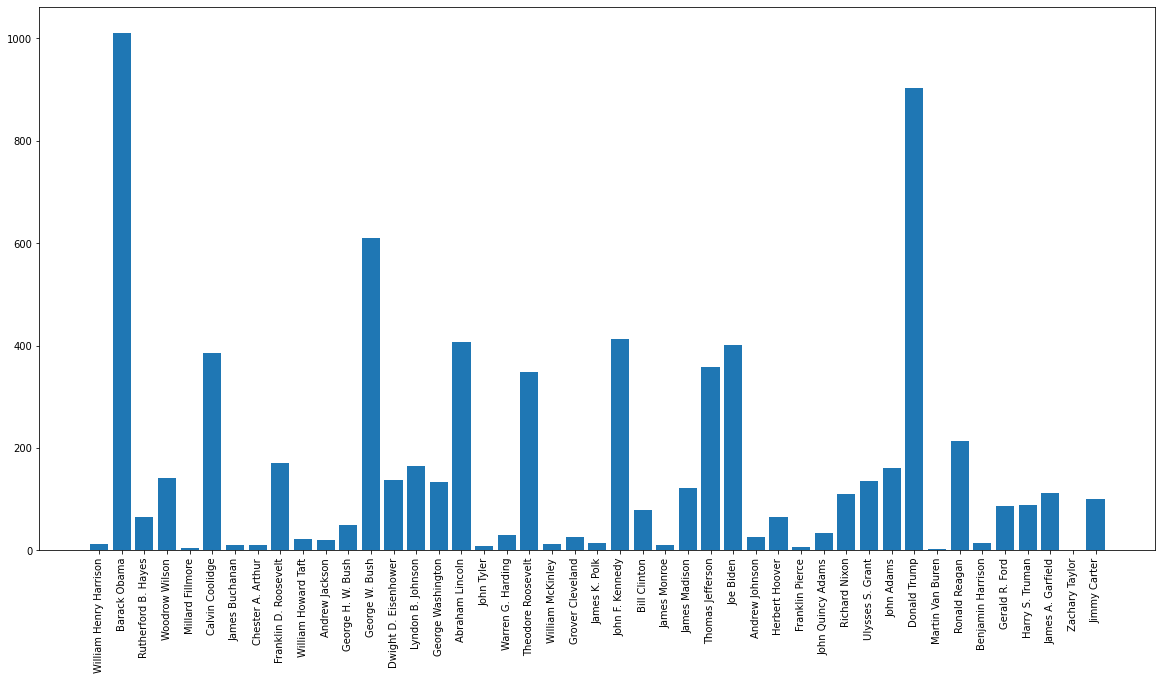

In [40]:
# plot the number of quotes per president
# label every president with more than 2 std deviations from the mean
plt.figure(figsize=(20, 10))
plt.bar(pquotes.keys(), [len(qs) for qs in pquotes.values()])
plt.xticks(rotation=90)
plt.show()


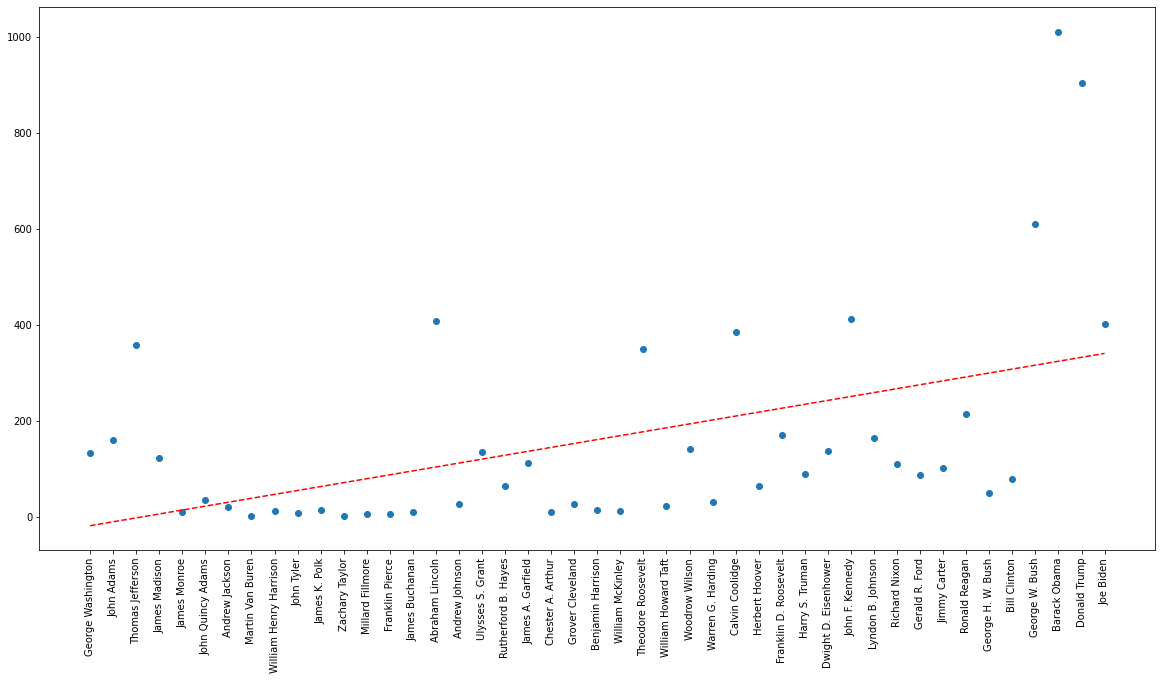

In [76]:
# scatter plot number of quotes versus order of presidency
plt.figure(figsize=(20, 10))
plt.scatter(range(len(pquotes)), [len(qs) for qs in pquotes.values()])
plt.xticks(range(len(pquotes)), pquotes.keys(), rotation=90)

# add a trendline
z = np.polyfit(range(len(pquotes)), [len(qs) for qs in pquotes.values()], 1)
p = np.poly1d(z)
plt.plot(range(len(pquotes)), p(range(len(pquotes))), "r--")

plt.show()


In [29]:
for key in pquotes:
    random.shuffle(pquotes[key])

pquotes = {
    pres: [q for q in qs if 10 < len(q) < 400][:10]
    for pres, qs in pquotes.items()
}

In [30]:
for name, qs in pquotes.items():
    create_quizes(qs, presidents[name.replace(" ", "_")])

Quiz created. id=1 quote='[F]ree Negroes who have served in this army are very much dissatisfied at being discarded. As it is to be apprehended that they may seek employ in the Ministerial Army, I have … given license for their being enlisted.' correct_answer='George Washington' choices=['Andrew Jackson', 'Woodrow Wilson', 'Thomas Jefferson', 'George Washington']
Quiz created. id=2 quote="Mrs. Phillis: Your favour of the 26th of October did not reach my hands 'till the middle of December. Time enough, you will say, to have given an answer ere this. Granted. But a variety of important occurrences, continually interposing to distract the mind and withdraw the attention, I hope will apologize for the delay, and plead my excuse for the seeming, but not real neglect." correct_answer='George Washington' choices=['James Madison', 'Barack Obama', 'Theodore Roosevelt', 'George Washington']
Quiz created. id=3 quote='One of the expedients of party to acquire influence, within particular districts

In [31]:
sess = sessionmaker(bind=engine)()

In [32]:
all_quizes = [q for q  in sess.query(Tables.Quiz).all()]

In [33]:
len(all_quizes)

397

In [83]:
qr = Tables.QuizRecord(
    quiz_id=all_quizes[0].id,
    player_id=1,
    correct=True,
    guess=all_quizes[0].correct_answer,
)

In [84]:
sess.add(qr)
sess.commit()


In [85]:
# drop all quiz records
sess = sessionmaker(bind=engine)()
sess.query(Tables.QuizRecord).delete()
sess.commit()
sess.close()

In [99]:
# connect to test_pap.db
engine = create_engine("sqlite:///pap.db")
Session = sessionmaker(bind=engine)
session = Session()

In [94]:
# get all quiz records with player id 53653440245
qrs = session.query(Tables.QuizRecord).filter(
    Tables.QuizRecord.player_id == 53653440245
).all()

In [97]:
sum([qr.correct for qr in qrs]) / len(qrs)

0.5

In [100]:
# count the number of distinct players
session.query(Tables.QuizRecord.player_id).distinct().count()

2080